In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Load the dataset
dataset, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)

# Split the dataset
train_dataset = dataset['train']

# Preprocessing function for images
def preprocess_image(image, label):
    image = tf.image.resize(image, (64, 64))
    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

# Apply the preprocessing
train_images = []
for image, label in train_dataset:
    preprocessed_img = preprocess_image(image, label).numpy()
    train_images.append(preprocessed_img)
preprocessed_images = np.array(train_images)

# Generate example descriptions
num_samples = preprocessed_images.shape[0]  # Assuming this matches the number of images
example_texts = ["This is a red flower", "A blue and yellow flower", "White petals", "Purple and white flower", "Yellow sunflower"]
texts = example_texts * (num_samples // len(example_texts))  # Repeat to match the number of samples
texts = texts[:num_samples]  # Ensure the length matches

# Tokenize and pad text sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_len = 20
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
vocab_size = len(tokenizer.word_index) + 1


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteNDEF11/oxford_flowers102-train.tfrecord*…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteNDEF11/oxford_flowers102-test.tfrecord*.…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteNDEF11/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [4]:
from tensorflow.keras import layers

def build_generator(vocab_size, max_len):
    text_input = layers.Input(shape=(max_len,))
    text_embedding = layers.Embedding(vocab_size, 50)(text_input)
    text_lstm = layers.LSTM(128)(text_embedding)

    noise_input = layers.Input(shape=(100,))
    merged_input = layers.Concatenate()([text_lstm, noise_input])

    x = layers.Dense(128 * 8 * 8, activation="relu")(merged_input)
    x = layers.Reshape((8, 8, 128))(x)

    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same")(x)
    output_img = layers.Activation("tanh")(x)

    model = tf.keras.Model([text_input, noise_input], output_img)
    return model

# Define the generator
generator = build_generator(vocab_size, max_len)
generator.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 20, 50)               650       ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 (None, 128)                  91648     ['embedding[0][0]']           
                                                                                                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                              

In [5]:
def build_discriminator(vocab_size, max_len):
    img_input = layers.Input(shape=(64, 64, 3))
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(img_input)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = layers.ZeroPadding2D(padding=((0,1),(0,1)))(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    img_features = layers.Dense(512)(x)

    text_input = layers.Input(shape=(max_len,))
    text_embedding = layers.Embedding(vocab_size, 50)(text_input)
    text_lstm = layers.LSTM(128)(text_embedding)

    combined_features = layers.Concatenate()([img_features, text_lstm])
    validity = layers.Dense(1, activation='sigmoid')(combined_features)

    model = tf.keras.Model([img_input, text_input], validity)
    return model

# Define the discriminator
discriminator = build_discriminator(vocab_size, max_len)
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           3136      ['input_3[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)           0         ['conv2d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 32, 32, 64)           0         ['leaky_re_lu[0][0]']         
                                                                                            

In [6]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    noise_input = layers.Input(shape=(100,))
    text_input = layers.Input(shape=(max_len,))
    generated_img = generator([text_input, noise_input])
    validity = discriminator([generated_img, text_input])

    model = tf.keras.Model([text_input, noise_input], validity)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))
    return model

gan = build_gan(generator, discriminator)
gan.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 model (Functional)          (None, 64, 64, 3)            2365517   ['input_6[0][0]',             
                                                                     'input_5[0][0]']             
                                                                                                  
 model_1 (Functional)        (None, 1)                    9407179   ['model[0][0]',         

1/1 [==============================] - 0s 122ms/step
0 [D loss: 4.002971508043629e-06, acc.: 100.00%] [G loss: 5.131462785357144e-06]
1/1 [==============================] - 0s 59ms/step


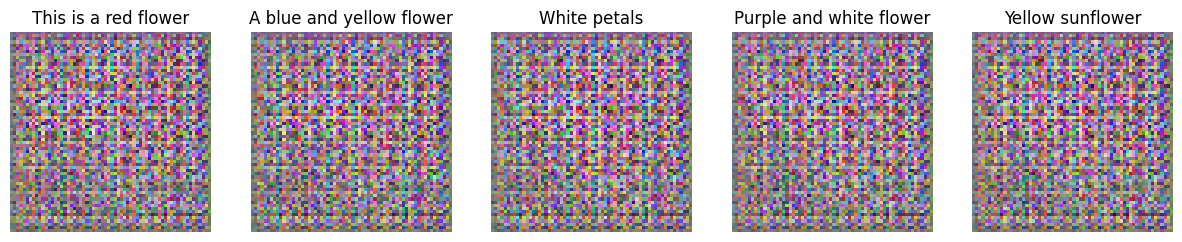

1/1 [==============================] - 0s 118ms/step
1 [D loss: 1.1071078915847465e-05, acc.: 100.00%] [G loss: 1.6306912584695965e-06]
1/1 [==============================] - 0s 111ms/step
2 [D loss: 4.070626118846121e-06, acc.: 100.00%] [G loss: 2.7611395125859417e-06]
1/1 [==============================] - 0s 212ms/step
3 [D loss: 2.749466005980139e-06, acc.: 100.00%] [G loss: 4.14157466366305e-06]
1/1 [==============================] - 0s 180ms/step
4 [D loss: 4.9777277126850095e-06, acc.: 100.00%] [G loss: 5.150051038071979e-06]
1/1 [==============================] - 0s 208ms/step
5 [D loss: 3.463065695541445e-06, acc.: 100.00%] [G loss: 2.8005590593238594e-06]
1/1 [==============================] - 0s 216ms/step
6 [D loss: 4.532567174919677e-06, acc.: 100.00%] [G loss: 7.87503995525185e-06]
1/1 [==============================] - 1s 674ms/step
7 [D loss: 4.0542496208217926e-05, acc.: 100.00%] [G loss: 1.6127687558764592e-05]
1/1 [==============================] - 0s 196ms/step
8 [D

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def train_gan(generator, discriminator, gan, epochs, batch_size, texts, images):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Select a random batch of images and texts
        idx = np.random.randint(0, images.shape[0], batch_size)
        real_images = images[idx]
        text_batch = texts[idx]

        # Generate a batch of new images
        noise = np.random.normal(0, 1, (batch_size, 100))
        generated_images = generator.predict([text_batch, noise])

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch([real_images, text_batch], real)
        d_loss_fake = discriminator.train_on_batch([generated_images, text_batch], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch([text_batch, noise], real)

        # Print the progress
        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss}]")

        # Save generated images every few epochs
        if epoch % 100 == 0:
            sample_images(generator, epoch, tokenizer)

def sample_images(generator, epoch, tokenizer):
    noise = np.random.normal(0, 1, (5, 100))
    example_texts = ["This is a red flower", "A blue and yellow flower", "White petals", "Purple and white flower", "Yellow sunflower"]
    sequences = tokenizer.texts_to_sequences(example_texts)
    padded_seqs = pad_sequences(sequences, maxlen=max_len, padding='post')

    gen_images = generator.predict([padded_seqs, noise])
    gen_images = 0.5 * gen_images + 0.5  # Rescale to [0, 1]

    fig, axs = plt.subplots(1, 5, figsize=(15, 15))
    for i in range(5):
        axs[i].imshow(gen_images[i])
        axs[i].axis('off')
        axs[i].set_title(example_texts[i])
    plt.show()

# Train the GAN
train_gan(generator, discriminator, gan, epochs=100, batch_size=32, texts=padded_sequences, images=preprocessed_images)


1/1 [==============================] - 0s 32ms/step


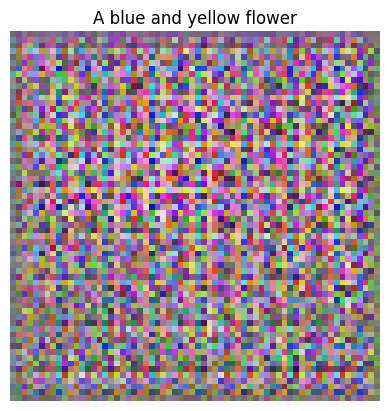

In [14]:
def generate_image(generator, tokenizer, text, noise_dim=100):
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post')
    noise = np.random.normal(0, 1, (1, noise_dim))
    generated_image = generator.predict([padded_seq, noise])
    generated_image = 0.5 * generated_image + 0.5  # Rescale to [0, 1]
    plt.imshow(generated_image[0])
    plt.axis('off')
    plt.title(text)
    plt.show()

# Example usage
generate_image(generator, tokenizer, "A blue and yellow flower")
